In [1]:
# from IPython.utils import io
# with io.capture_output() as captured:
#   !pip3 install scikit-learn;

import numpy as np

from util import train_test_df, evaluate, interaction_matrix, heatmaps, train_test_mtx
from mfactorization import mf, mf_default_config


def pca(M):
  '''
  reduces dimension of nxm matrix M to nx64
  '''

  from sklearn.decomposition import PCA

  R = PCA(64).fit_transform(M)

  return R

implict loading of dataframes
Max items of a user in test dataset: 36


In [2]:
# 1.
R, Rt = train_test_mtx(return_dfs=False, return_id_maps=False)

# 2 Matrix Factorization

In [3]:
# 2.
print("factorizing interaction matrix:")

Q, P = mf(R, print_step=8, lr =(1e-2, 1e-3), n_epochs=800, sampled_epochs=700, sample_size=0.05)
Rm = Q @ P.T

factorizing interaction matrix:


103it [00:02, 51.17it/s]

err: 1.36e+04, lr: 0.0067663 

205it [00:03, 80.29it/s]

err: 1.19e+04, lr: 0.0045479 , last batch: 32


297it [00:04, 66.79it/s]

err: 1.09e+04, lr: 0.0031829 , last batch: 8


394it [00:06, 55.58it/s]

err: 9.94e+03, lr: 0.0023431 , last batch: 8


484it [00:08, 50.53it/s]

err: 9.12e+03, lr: 0.0018264 , last batch: 4


578it [00:10, 38.70it/s]

err: 8.40e+03, lr: 0.0015084 , last batch: 2


676it [00:13, 27.22it/s]

err: 7.80e+03, lr: 0.0012888 , last batch: 1


769it [00:17, 29.98it/s]

err: 7.27e+03, lr: 0.0010705 , last batch: 1


800it [00:18, 43.68it/s]

best error: 7.20e+03


# 3. BERT

In [4]:
# 3.
E = np.load('save/roberta_item_encodings.npy')

# 3.a
Pa = pca(E)
Ra = Q @ Pa.T

# 3.b
Pb = pca(np.hstack((E, P)))
Rb = Q @ Pb.T

# 4. evaluation

In [5]:
# 4.

# 4. MF
Em = evaluate(Rm)

# 4. BERT a
Ea = evaluate(Ra)
# 4. BERT b
Eb = evaluate(Rb)

# 4. Extra evaluations
E0 = evaluate(R)
Et = evaluate(Rt)

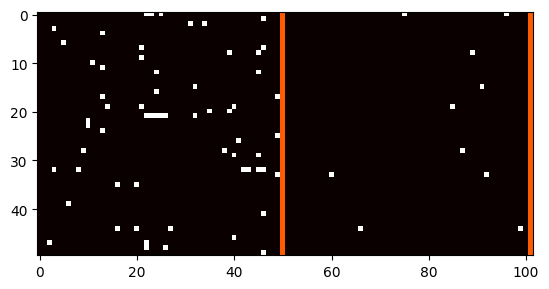

In [6]:
from util import heatmaps
heatmaps([R[0:50, 0:50], Rt[0:50, 0:50]])

Mistake in the problem: the corresponding matrix for items is P (not Q)

In [7]:
import pandas as pd

columns = E0.keys()
df = pd.DataFrame(data=(E0, Et, Em, Ea, Eb), columns=columns)

df.insert(0, 'method', [
    'R (train data)',
    'R (test data)',
    'matrix factorization',
    'BERT replace Q',
    'BERT concat with Q'
])

df

,method,recall,ndcg,rank correlation
0,R (train data),3.847,0.007,1.000
1,R (test data),99,1.000,1.000
2,matrix factorization,28,0.132,-0.006
3,BERT replace Q,2.262,0.004,0.010
4,BERT concat with Q,3.393,0.010,0.022


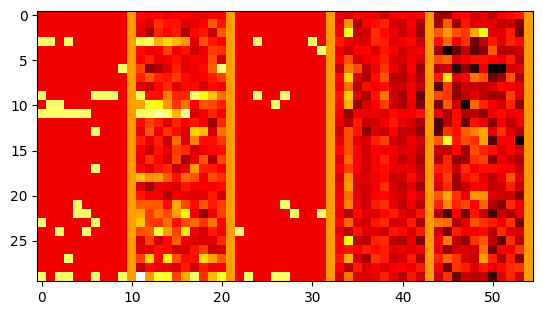

In [12]:
def find_window(w, h):
    '''
    returns a frame with most available test items
    '''
    n, m = Rt.shape
    a = np.zeros((n-h, m-w))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            a[i,j] = Rt[i:i+h, j:j+w].sum()
    
    return np.unravel_index(a.argmax(), a.shape)

try:
    a = i, j
except:
    i, j = -1, -1

def win(M, width=10, height=30):
    global i, j
    if i < 0 and j < 0:
        i, j = find_window(width, height)

    return M[i:i+height, j:j+width]


RRmRtRaRb = (R, Rm, Rt, Ra, Rb)
RRmRtRaRb = [win(M) for M in RRmRtRaRb]

heatmaps(RRmRtRaRb)
# heatmaps([M*win(Rt) for M in RRmRtRaRb])

Lets see agreement of results with Rt in a better way

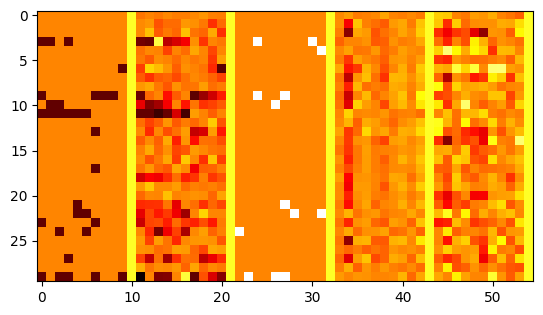

In [13]:
def mark(M, windowed=True):
    '''
    highlight M in such a way:
    if M agrees with test, it gets brighter
    if M disgrees with test, it gets darker
    '''

    T = win(Rt) if windowed else Rt
    M = M.copy()
    M[T == 0] = -1 * M[T == 0]
    M[(M<0.5) & (T==1)] = 0
    return M

heatmaps([mark(win(M)) for M in (R, Rm, Rt, Ra, Rb)])

In [14]:
print("We expect R_train to have almost zero score (since it has zero value for almost every item)")
print(E0)
print()

print("We expect R_test to have almost 1 score (since it has memorized test dataset)")
print(Et)
print()

print("R estimation (with matrix factorization)")
print(Em)
print()

print("Replace Q with BERT's encoding")
print(Ea)
print()

print("Concat BERT encoding")
print(Eb)
print()

We expect R_train to have almost zero score (since it has zero value for almost every item)
{'recall': '3.847', 'ndcg': '0.007', 'rank correlation': '1.000'}

We expect R_test to have almost 1 score (since it has memorized test dataset)
{'recall': '99', 'ndcg': '1.000', 'rank correlation': '1.000'}

R estimation (with matrix factorization)
{'recall': '28', 'ndcg': '0.132', 'rank correlation': '-0.006'}

Replace Q with BERT's encoding
{'recall': '2.262', 'ndcg': '0.004', 'rank correlation': '0.010'}

Concat BERT encoding
{'recall': '3.393', 'ndcg': '0.010', 'rank correlation': '0.022'}



What if we improve Pa further

In [15]:
Qa, Pa2 = mf(R, qp=(Q, Pb), lr=(1e-2, 1e-3), n_epochs=2, sampled_epochs=1, print_step=1, log_step=1) 
Ra2 = Qa @ Pa2.T
evaluate(Ra2)

0it [00:00, ?it/s]

2it [00:00, 13.36it/s]


best error: 1.77e+04


{'recall': '6.483', 'ndcg': '0.023', 'rank correlation': '0.024'}

In [ ]:
from util.data_reader import train_test_df

df, dft = train_test_df()

